In [4]:
MASKS_DIR = ''../Queen_snakes_masks''
IMAGES_DIR = '../images'

In [5]:
import os

masks = sorted([f"{MASKS_DIR}/{i}" for i in os.listdir(MASKS_DIR)])
images = sorted([f"{IMAGES_DIR}/{i}" for i in os.listdir(IMAGES_DIR)])

FileNotFoundError: [Errno 2] No such file or directory: '../Queen_snakes_masks'

In [267]:
# Check if all images have masks
for image in images:
    image_name = images[0].split('.png.jpg', 1)[0].rsplit('/', 1)[1]
    if f"{image_name}_mask.png.jpg" not in [m.rsplit('/', 1)[1] for m in masks]:
        print(f"Mask not found for image: {image}")

In [268]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [269]:
def merge_mask_with_image(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    masked_image = cv2.bitwise_and(image, image, mask=binary_mask)
    return masked_image


In [270]:
def display_image(image, title="Image"):
    """Display an image using matplotlib."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


def display_images(images, titles):
    """Display multiple images using matplotlib."""
    fig, axs = plt.subplots(1, len(images), figsize=(20, 20))
    for i, (image, title) in enumerate(zip(images, titles)):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(image_rgb)
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

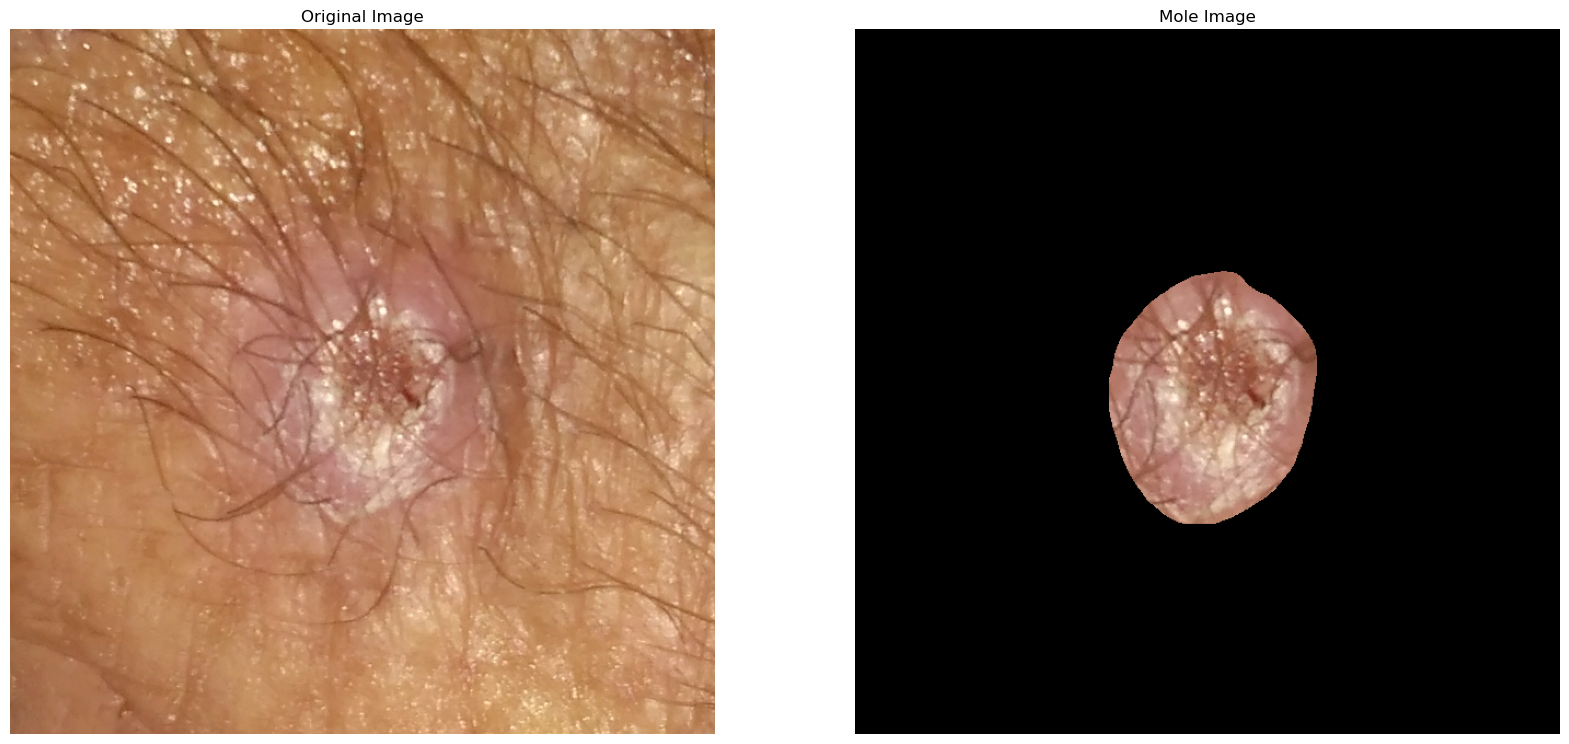

In [271]:
image_with_hair = list(filter(lambda x: x.endswith("PAT_406_808_560.png.jpg"), images))
image_with_hair_index = images.index(image_with_hair[0])

original_image = cv2.imread(images[image_with_hair_index])
mole_image = merge_mask_with_image(images[image_with_hair_index], masks[image_with_hair_index])

display_images([original_image, mole_image], ["Original Image", "Mole Image"])

In [272]:
# remove hair using dull razor algorithm
# source: https://github.com/BlueDokk/Dullrazor-algorithm/blob/main/dullrazor.py
def remove_hair(img):
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Black hat filter
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    # plt.imshow(grayScale)
    # plt.show()
    # plt.imshow(blackhat)
    # plt.show()
    # plt.imshow(bhg)
    # plt.show()
    # plt.imshow(mask)
    # plt.show()
    # 
    return dst

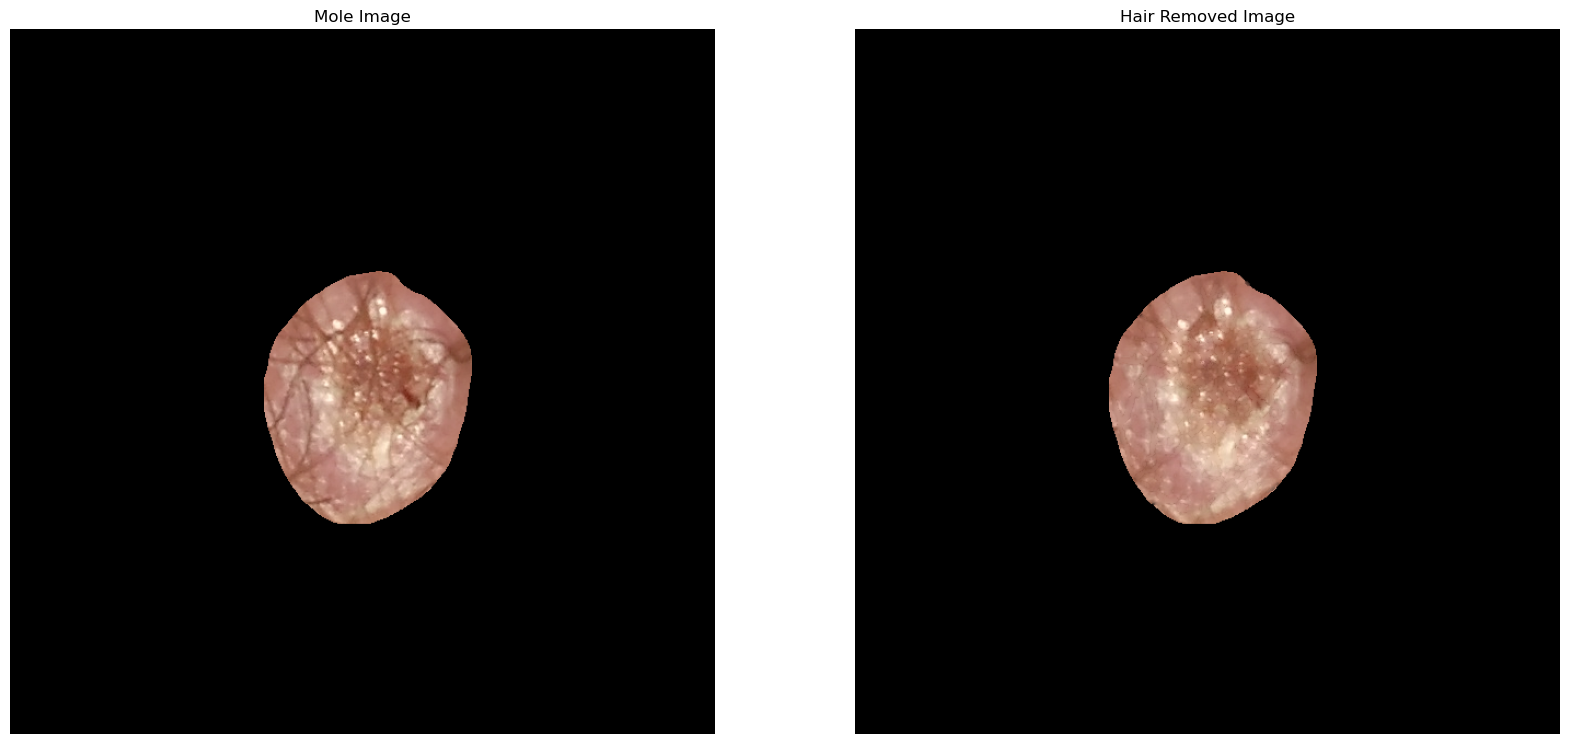

In [273]:
hair_removed = remove_hair(mole_image)
display_images([mole_image, hair_removed], ["Mole Image", "Hair Removed Image"])

In [2]:
# detect presence of the following colors in the image
# white
# red
# light brown
# dark brown
# blue-gray
# black
# using HSV color space
color_ranges = {
    "white": [([0, 180], [0, 50], [200, 255])],
    "red": [([0, 10], [100, 255], [50, 255]), ([170, 180], [100, 255], [50, 255])],
    "light_brown": [([10, 20], [50, 150], [100, 200])],
    "dark_brown": [([10, 20], [100, 255], [50, 100])],
    "blue_gray": [([100, 120], [10, 100], [40, 120])],
    "black": [([0, 180], [0, 254], [0, 50])]
}

# Define color tresholds for each color
color_tresholds = {
    "white": 0.05,
    "red": 0.05,
    "light_brown": 0.05,
    "dark_brown": 0.05,
    "blue_gray": 0.05,
    "black": 0.05
}



In [275]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


def display_hsv_spectrum(color_range, title='HSV Spectrum'):
    # Extract HSV ranges from the dictionary
    h_range = color_range[0]
    s_range = color_range[1]
    v_range = color_range[2]

    # Create a 100x300 image (100 pixels for Hue and 300 for Saturation gradient)
    hsv_img = np.zeros((100, 300, 3), dtype=np.uint8)

    # Fill the image with the HSV values
    for i in range(100):  # Varying Saturation from 0 to max
        saturation = np.interp(i, [0, 99], s_range)
        for j in range(300):  # Varying Hue from 0 to 360
            hue = np.interp(j, [0, 299], h_range)
            hsv_img[i, j] = [hue, saturation, v_range[1] * 2.55]  # Convert V to 0-255 scale

    # Convert HSV to RGB for display
    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

    # Display the image
    plt.figure(figsize=(10, 4))
    plt.imshow(rgb_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [3]:
for k, v in color_ranges.items():
    for i, color_range in enumerate(v):
        display_hsv_spectrum(color_range, title=f"{k.capitalize()} Color Range {i + 1}")

NameError: name 'display_hsv_spectrum' is not defined

In [277]:
def find_pixels_inside_mask(img):
    return np.count_nonzero(img)


In [278]:
def detect_colors(image, color_ranges):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    masks = {}

    # Create a mask that ignores fully black pixels
    ignore_black = cv2.inRange(image, (1, 1, 1), (255, 255, 255))

    for color, ranges in color_ranges.items():
        color_mask = None

        for h_range, s_range, v_range in ranges:
            lower = np.array([h_range[0], s_range[0], v_range[0]])
            upper = np.array([h_range[1], s_range[1], v_range[1]])
            temp_mask = cv2.inRange(hsv_image, lower, upper)

            if color_mask is None:
                color_mask = temp_mask
            else:
                color_mask = cv2.bitwise_or(color_mask, temp_mask)

        # Apply the ignore black mask
        color_mask = cv2.bitwise_and(color_mask, ignore_black)

        masks[color] = color_mask

    return masks

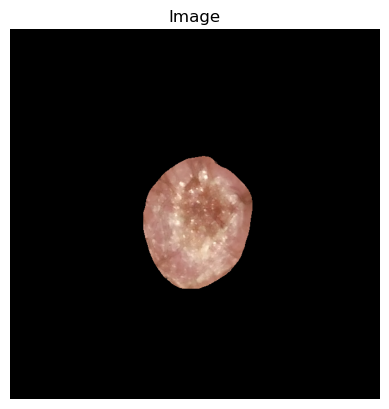

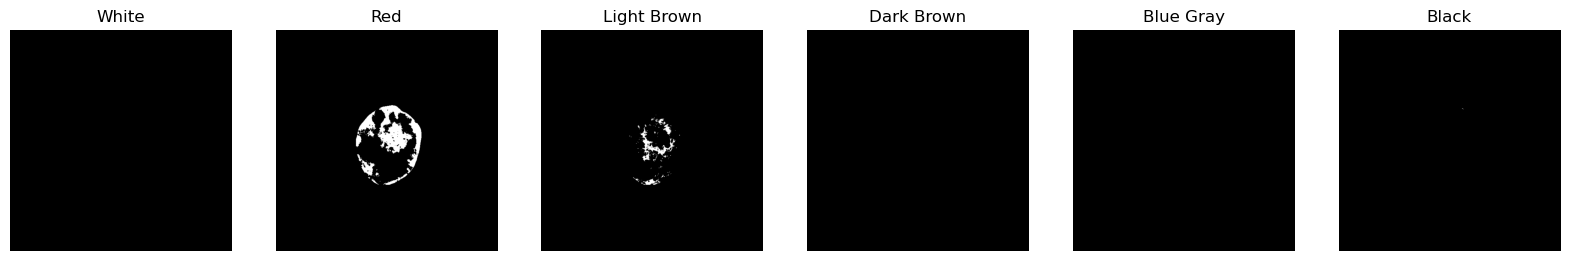

In [279]:
display_image(hair_removed)
color_masks = detect_colors(hair_removed, color_ranges, )
display_images([color_masks["white"], color_masks["red"], color_masks["light_brown"], color_masks["dark_brown"],
                color_masks["blue_gray"], color_masks["black"]],
               ["White", "Red", "Light Brown", "Dark Brown", "Blue Gray", "Black"])

In [280]:
def calculate_color_ratio(color_mask, mole_mask, color_name):
    color_pixels = find_pixels_inside_mask(color_mask)
    mole_pixels = find_pixels_inside_mask(mole_mask)
    print(f"Color pixels ({color_name}): {color_pixels}, Mole pixels: {mole_pixels}")

    ratio = color_pixels / mole_pixels if mole_pixels > 0 else 0
    return ratio


In [281]:
def is_color_present(color_mask, mole_mask, treshold, color_name=''):
    ratio = calculate_color_ratio(color_mask, mole_mask, color_name)
    return ratio > treshold

In [282]:
for color, mask in color_masks.items():
    print(f"Is {color} present in mole: {is_color_present(mask, hair_removed, color_tresholds[color])}")

Color pixels (): 0, Mole pixels: 100212
Is white present in mole: False
Color pixels (): 12778, Mole pixels: 100212
Is red present in mole: True
Color pixels (): 3234, Mole pixels: 100212
Is light_brown present in mole: False
Color pixels (): 0, Mole pixels: 100212
Is dark_brown present in mole: False
Color pixels (): 0, Mole pixels: 100212
Is blue_gray present in mole: False
Color pixels (): 4, Mole pixels: 100212
Is black present in mole: False


In [283]:
def calculate_color_variance(img):
    image = img.copy()
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    channels = cv2.split(hsv_image)

    masked_channels = channels

    # Calculate the standard deviation for each channel
    std_devs = [np.std(ch[ch > 0]) for ch in masked_channels]  # Ignore zero values from masked areas
    return std_devs


In [284]:
def detect_colors_in_image(image_path, mask_path, color_ranges, color_tresholds):
    mole_image = merge_mask_with_image(image_path, mask_path)
    hair_removed = remove_hair(mole_image)
    
    color_masks = detect_colors(hair_removed, color_ranges)

    results = {}
    for color, mask in color_masks.items():
        results[color] = is_color_present(mask, hair_removed, color_tresholds[color], color)
        
    color_variance = calculate_color_variance(hair_removed)
    return (mole_image, hair_removed, results, color_variance)


In [285]:
def analyse_image(image_path, mask_path):
    results = detect_colors_in_image(image_path, mask_path, color_ranges, color_tresholds)
    display_images([results[0], results[1]], ["Mole Image", "Hair Removed Image"])
    # Display the results as a table
    print("Color\t\t\tPresent")
    print("-----\t\t\t-------")
    for color, present in results[2].items():
        print(f"{color.capitalize()}\t\t{present}")
        
    print("Color Variance")
    print("--------------")
    for i, variance in enumerate(results[3]):
        print(f"Channel {i + 1}: {variance}")
    print("\n")
    


Color pixels (white): 0, Mole pixels: 1294530
Color pixels (red): 399405, Mole pixels: 1294530
Color pixels (light_brown): 5252, Mole pixels: 1294530
Color pixels (dark_brown): 82, Mole pixels: 1294530
Color pixels (blue_gray): 0, Mole pixels: 1294530
Color pixels (black): 6, Mole pixels: 1294530


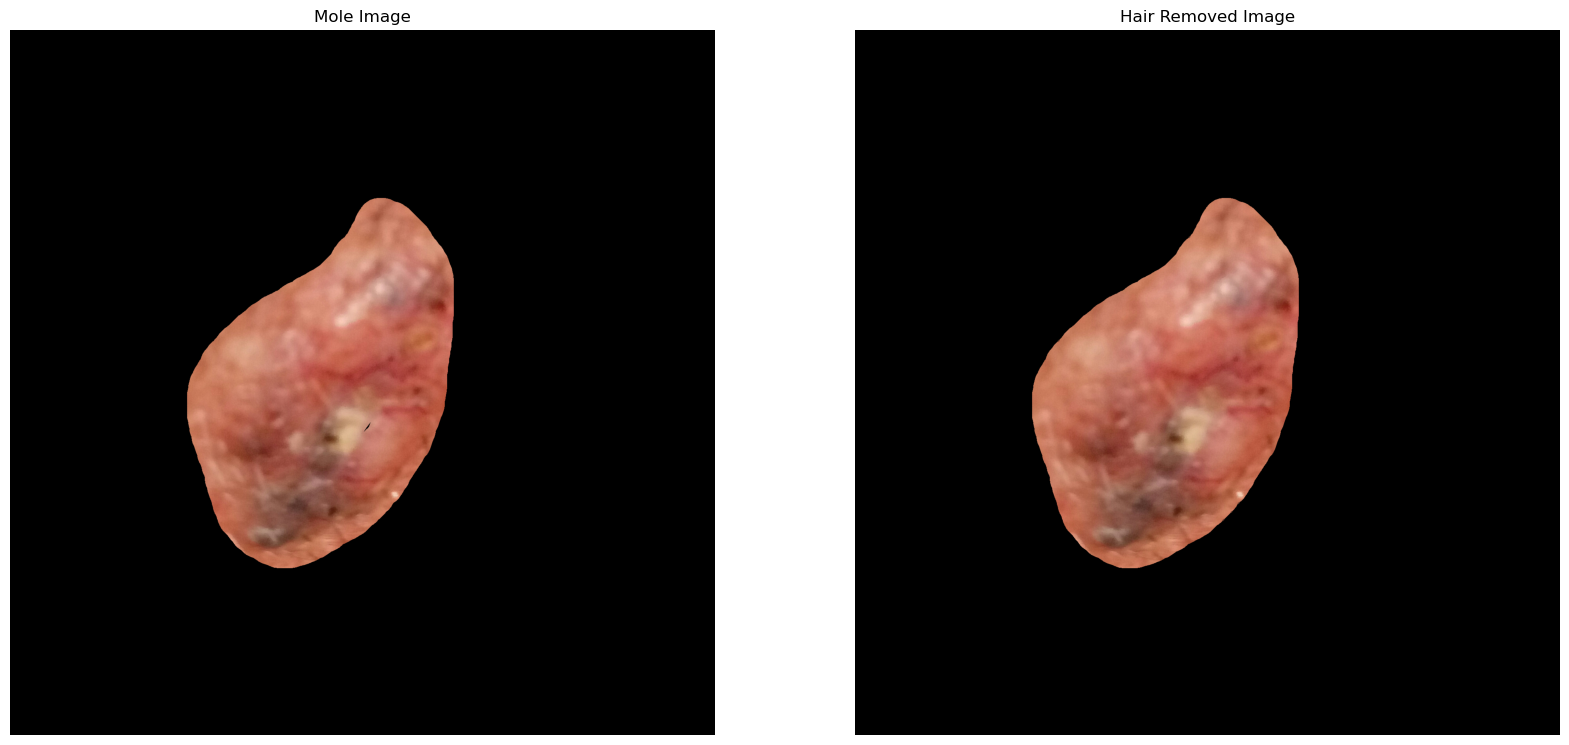

Color			Present
-----			-------
White		False
Red		True
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 2.0127434131612154
Channel 2: 21.455635450403907
Channel 3: 24.69136043801415


Color pixels (white): 0, Mole pixels: 8346
Color pixels (red): 143, Mole pixels: 8346
Color pixels (light_brown): 559, Mole pixels: 8346
Color pixels (dark_brown): 0, Mole pixels: 8346
Color pixels (blue_gray): 0, Mole pixels: 8346
Color pixels (black): 0, Mole pixels: 8346


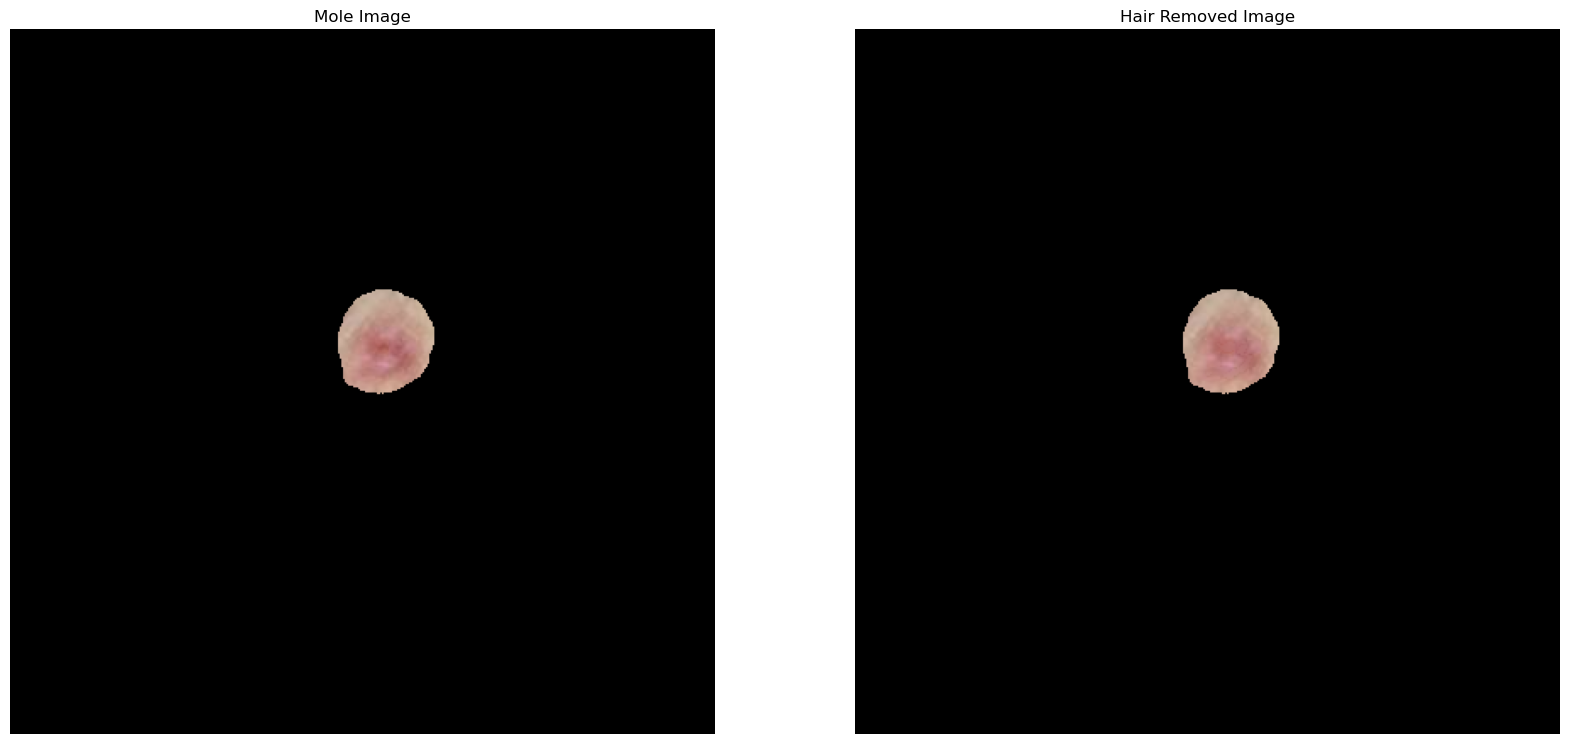

Color			Present
-----			-------
White		False
Red		False
Light_brown		True
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 41.53728546586015
Channel 2: 13.968745478606426
Channel 3: 8.07229255631268
Color pixels (white): 1102, Mole pixels: 1260966
Color pixels (red): 24511, Mole pixels: 1260966
Color pixels (light_brown): 50579, Mole pixels: 1260966
Color pixels (dark_brown): 6, Mole pixels: 1260966
Color pixels (blue_gray): 0, Mole pixels: 1260966
Color pixels (black): 14, Mole pixels: 1260966


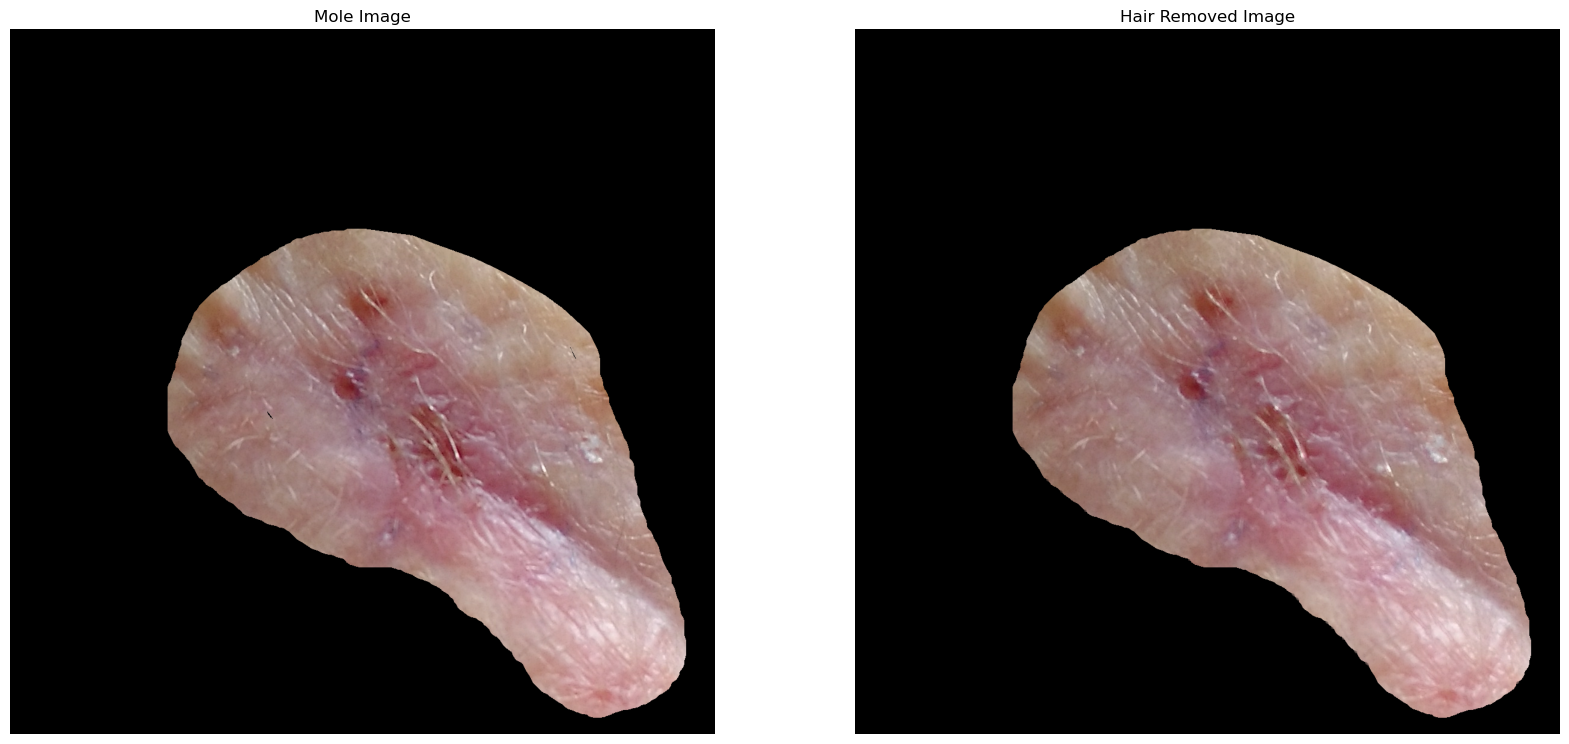

Color			Present
-----			-------
White		False
Red		False
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 83.10523284587553
Channel 2: 21.664119233968623
Channel 3: 21.59903615816525


Color pixels (white): 0, Mole pixels: 19077
Color pixels (red): 2880, Mole pixels: 19077
Color pixels (light_brown): 0, Mole pixels: 19077
Color pixels (dark_brown): 0, Mole pixels: 19077
Color pixels (blue_gray): 0, Mole pixels: 19077
Color pixels (black): 0, Mole pixels: 19077


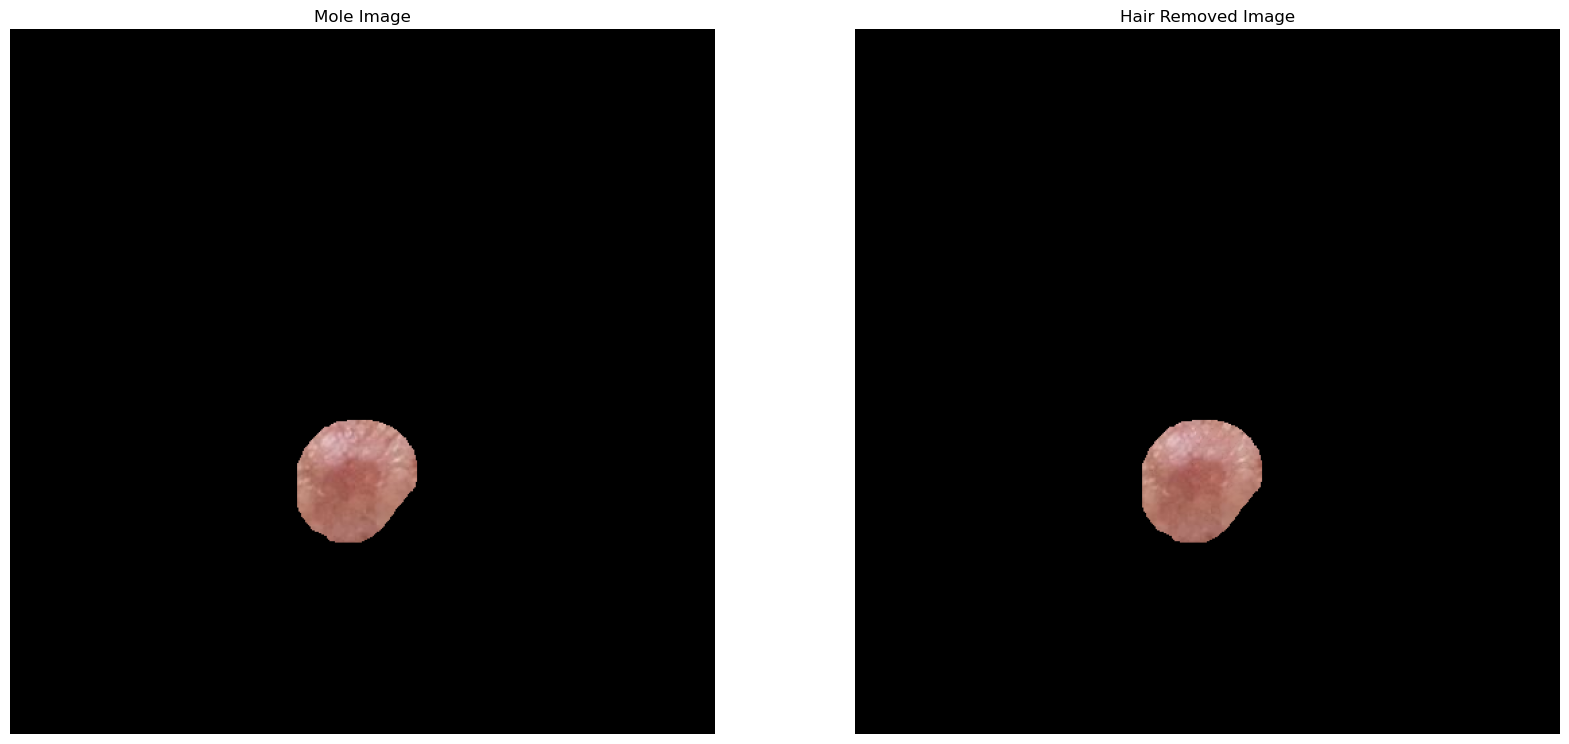

Color			Present
-----			-------
White		False
Red		True
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 38.563739619219945
Channel 2: 19.012646149574902
Channel 3: 15.995284888407356


Color pixels (white): 0, Mole pixels: 25164
Color pixels (red): 612, Mole pixels: 25164
Color pixels (light_brown): 935, Mole pixels: 25164
Color pixels (dark_brown): 0, Mole pixels: 25164
Color pixels (blue_gray): 0, Mole pixels: 25164
Color pixels (black): 0, Mole pixels: 25164


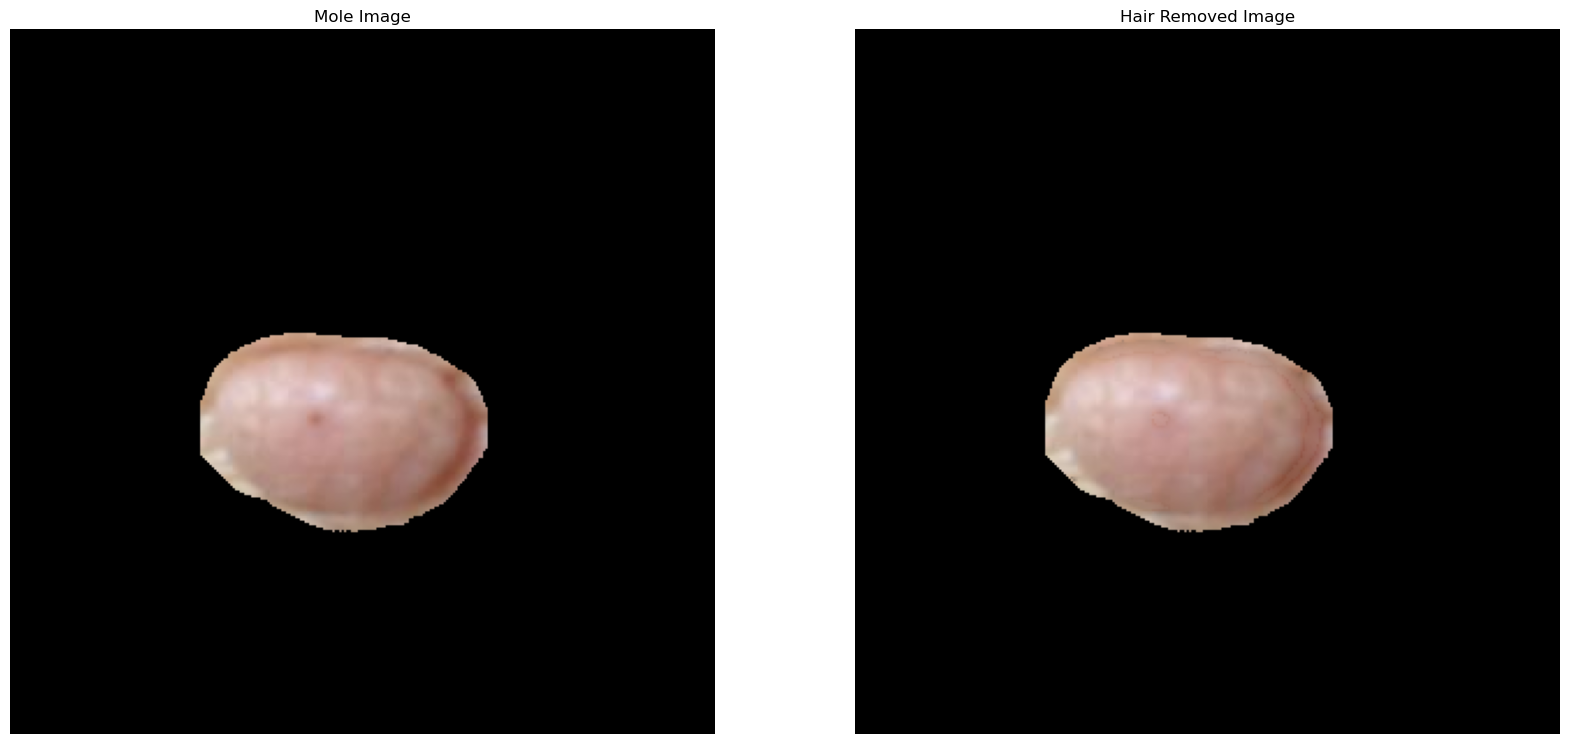

Color			Present
-----			-------
White		False
Red		False
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 24.223411026054336
Channel 2: 20.117315084853377
Channel 3: 21.755857398092232
Color pixels (white): 227, Mole pixels: 937284
Color pixels (red): 81569, Mole pixels: 937284
Color pixels (light_brown): 122698, Mole pixels: 937284
Color pixels (dark_brown): 28297, Mole pixels: 937284
Color pixels (blue_gray): 0, Mole pixels: 937284
Color pixels (black): 18, Mole pixels: 937284


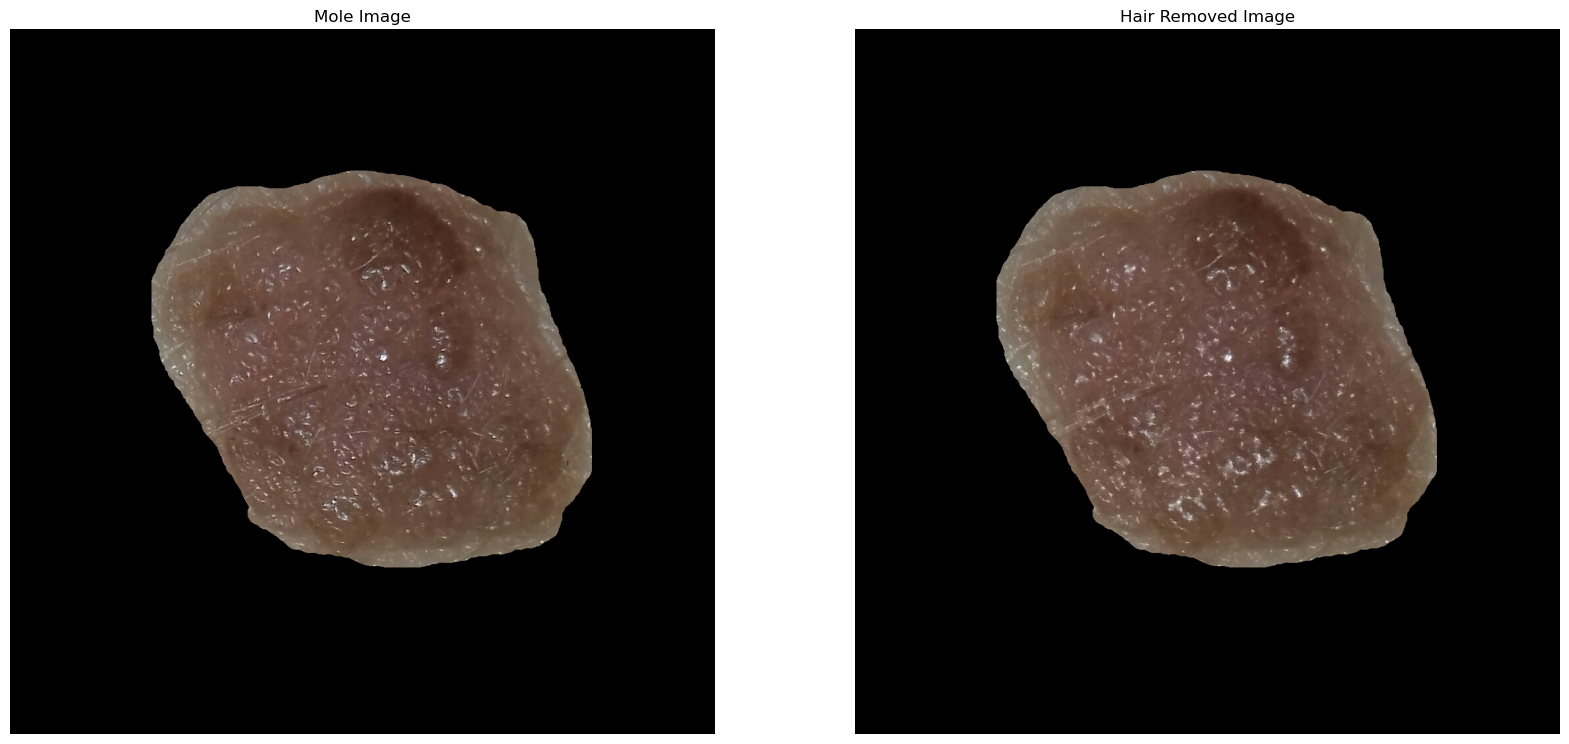

Color			Present
-----			-------
White		False
Red		True
Light_brown		True
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 4.118190555027106
Channel 2: 20.573426383900692
Channel 3: 17.035654543196184


Color pixels (white): 2365, Mole pixels: 1454078
Color pixels (red): 252078, Mole pixels: 1454078
Color pixels (light_brown): 232, Mole pixels: 1454078
Color pixels (dark_brown): 0, Mole pixels: 1454078
Color pixels (blue_gray): 0, Mole pixels: 1454078
Color pixels (black): 29, Mole pixels: 1454078


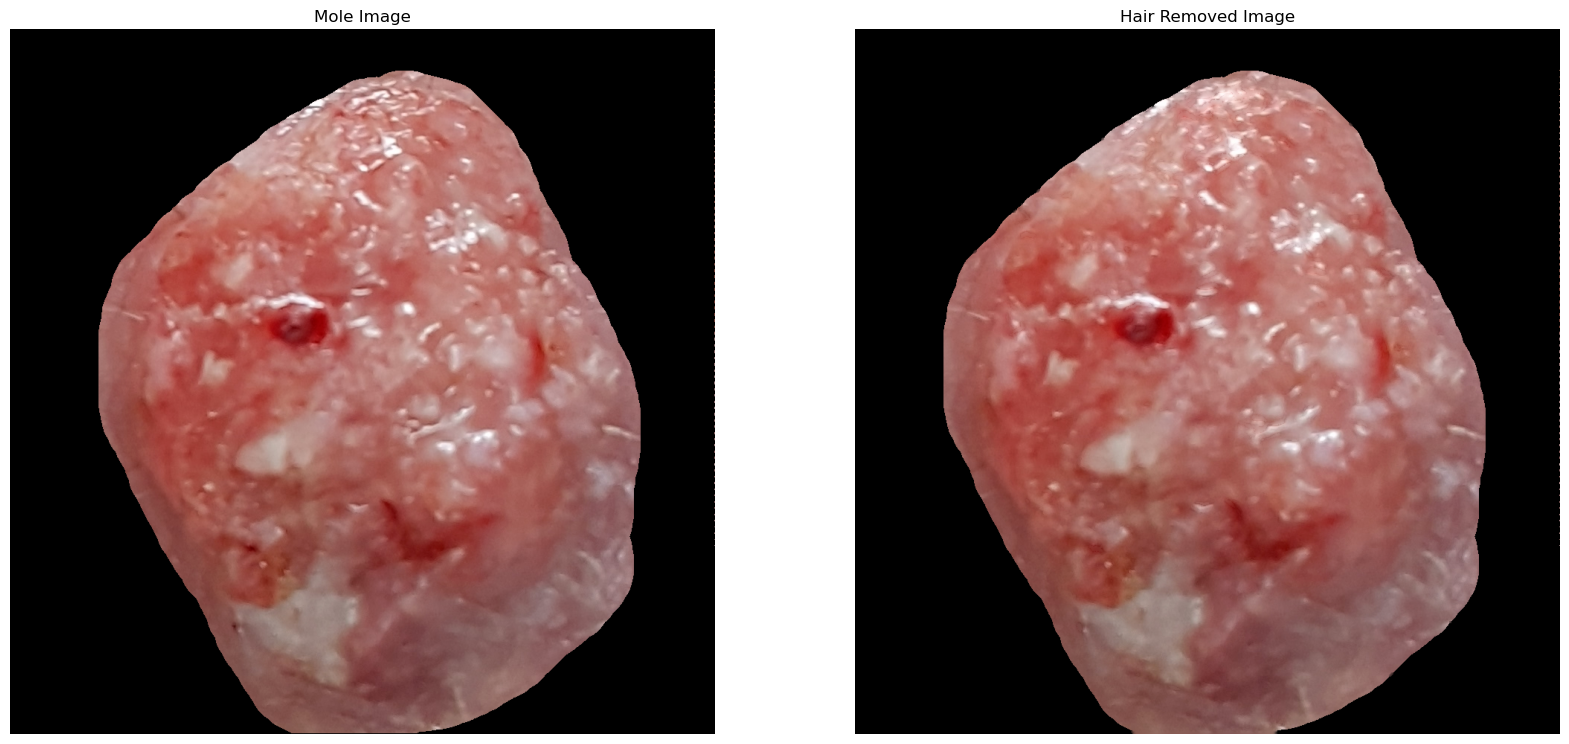

Color			Present
-----			-------
White		False
Red		True
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 51.300990876015206
Channel 2: 34.53198519008984
Channel 3: 25.523599851613355


Color pixels (white): 4, Mole pixels: 85383
Color pixels (red): 7520, Mole pixels: 85383
Color pixels (light_brown): 2729, Mole pixels: 85383
Color pixels (dark_brown): 152, Mole pixels: 85383
Color pixels (blue_gray): 0, Mole pixels: 85383
Color pixels (black): 5, Mole pixels: 85383


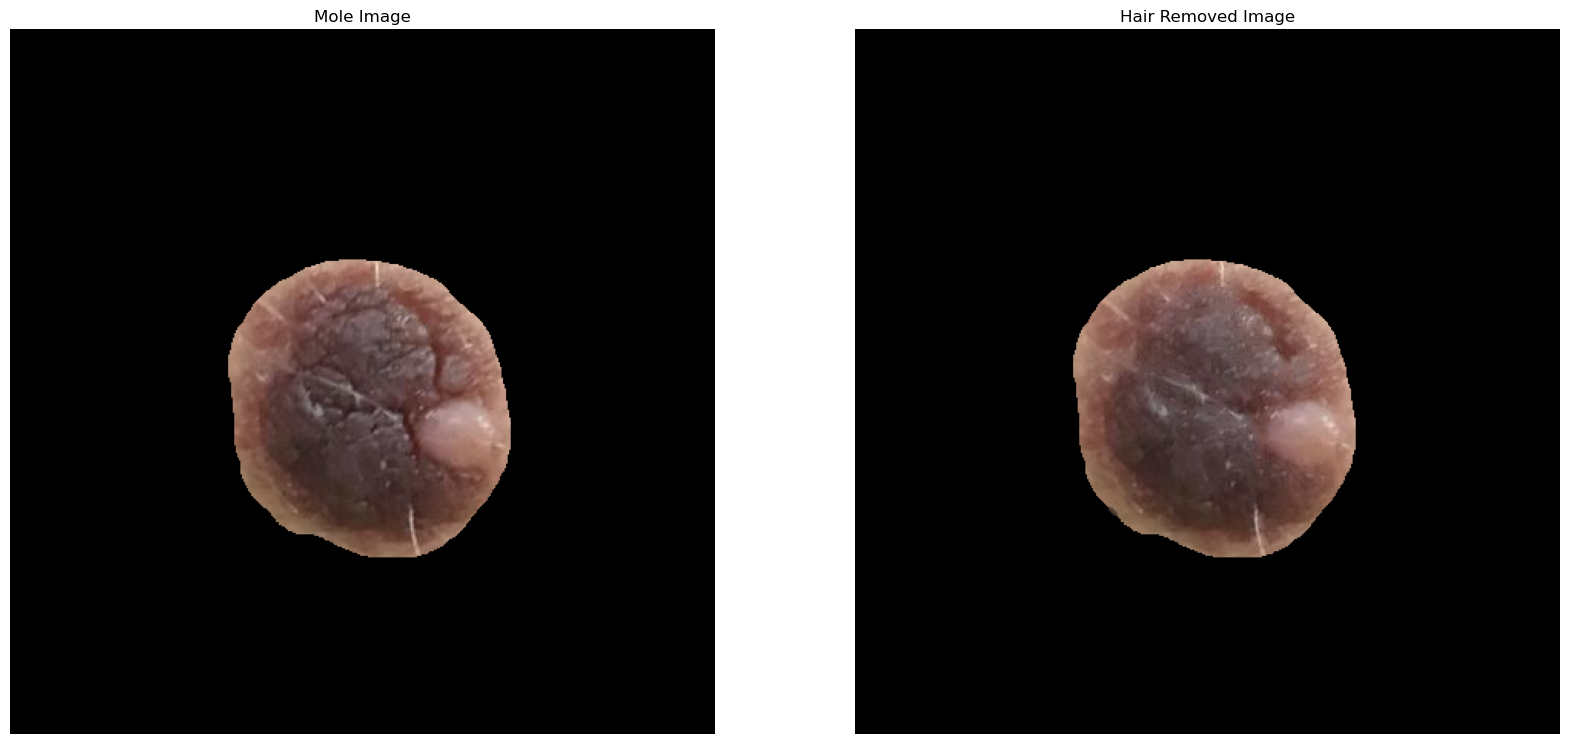

Color			Present
-----			-------
White		False
Red		True
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 60.12979177975048
Channel 2: 22.38538357177509
Channel 3: 37.43282459319679


Color pixels (white): 16, Mole pixels: 33570
Color pixels (red): 7451, Mole pixels: 33570
Color pixels (light_brown): 20, Mole pixels: 33570
Color pixels (dark_brown): 0, Mole pixels: 33570
Color pixels (blue_gray): 0, Mole pixels: 33570
Color pixels (black): 0, Mole pixels: 33570


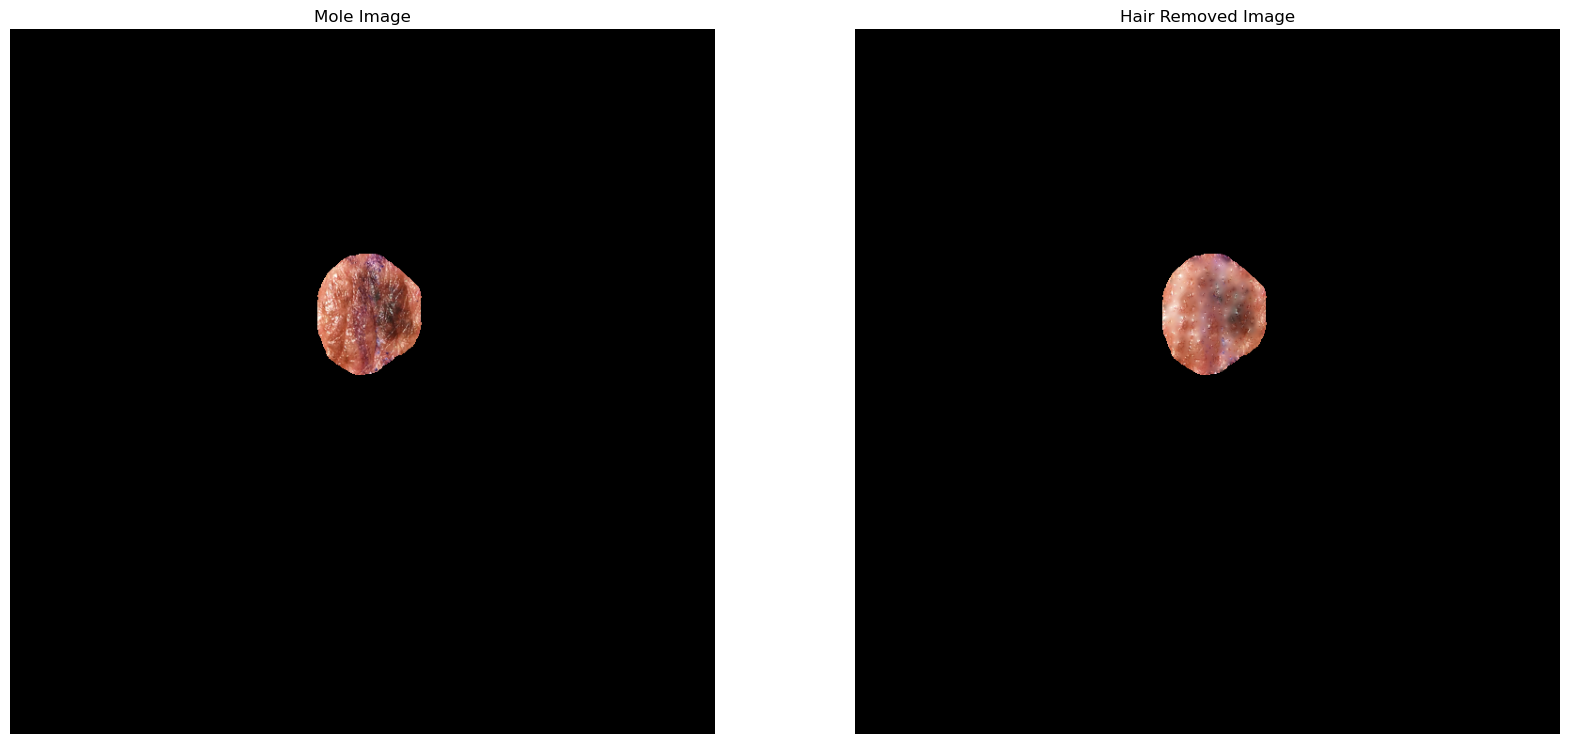

Color			Present
-----			-------
White		False
Red		True
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 46.51408678312835
Channel 2: 28.225603067474623
Channel 3: 34.0964847577038
Color pixels (white): 6, Mole pixels: 277947
Color pixels (red): 18072, Mole pixels: 277947
Color pixels (light_brown): 255, Mole pixels: 277947
Color pixels (dark_brown): 0, Mole pixels: 277947
Color pixels (blue_gray): 0, Mole pixels: 277947
Color pixels (black): 13, Mole pixels: 277947


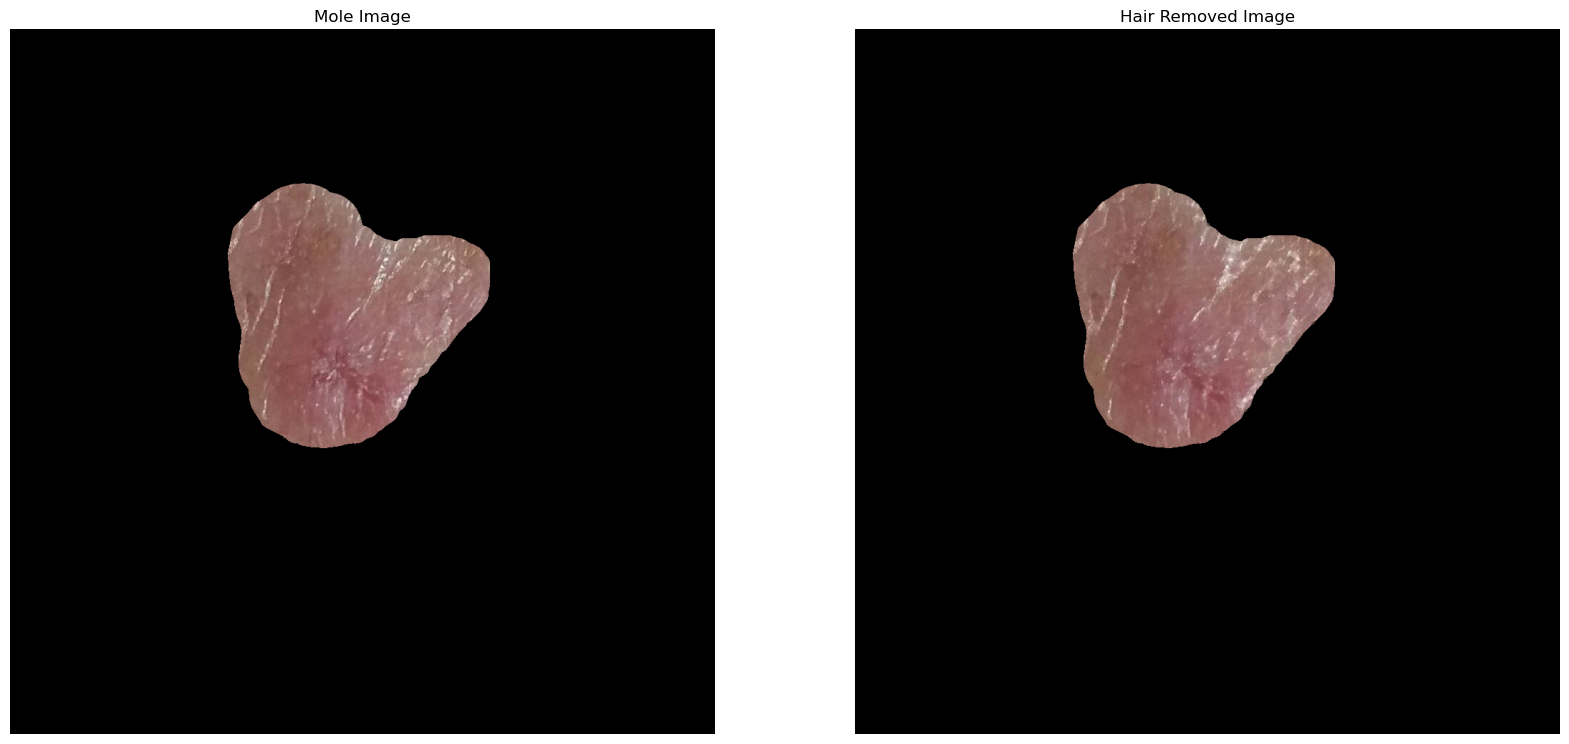

Color			Present
-----			-------
White		False
Red		True
Light_brown		False
Dark_brown		False
Blue_gray		False
Black		False
Color Variance
--------------
Channel 1: 70.80143588490051
Channel 2: 16.25092204382309
Channel 3: 15.414078973124047


In [286]:
for i in range(0, 10):
    analyse_image(images[i], masks[i])